<a href="https://colab.research.google.com/github/AlexanderSychev2005/brain_tumour_classification/blob/main/brain_tumour_presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Brain Tumor Detection using Tensorflow CNN

## Importing Libraries

In [1]:
import os
import kagglehub
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix

## Data Loading

In [2]:
# Download latest version
path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

In [3]:
path

'/kaggle/input/brain-tumor-classification-mri'

In [4]:
X_train = []
y_train = []
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

image_size = 256
for i in labels:
  folderPath = os.path.join(f'{path}/Training', i)
  for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
  folderPath = os.path.join(f'{path}/Testing', i)
  for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)


100%|██████████| 74/74 [00:00<00:00, 80.64it/s]


In [5]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [6]:
y_train

array(['glioma_tumor', 'glioma_tumor', 'glioma_tumor', ...,
       'pituitary_tumor', 'pituitary_tumor', 'pituitary_tumor'],
      dtype='<U16')

## Visualizatioin

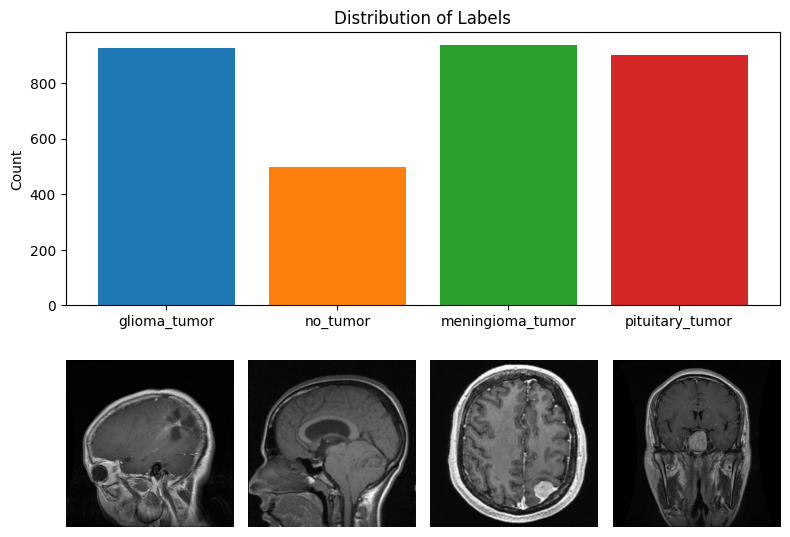

In [9]:
label_counts = {label: np.sum(y_train == label) for label in labels}

plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)

# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images from each label
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5)
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1

plt.tight_layout()
plt.show()

## Data augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20, # Rotate images by ±20 degrees
    width_shift_range=0.1, # Shift width by 10% of original size
    height_shift_range=0.1, # Shift height by 10% of the original size
    zoom_range=0.1, # Zoom in/out by 10%
    horizontal_flip=False, # Horizontal reflection prohibited
    vertical_flip=False,  # Vertical reflection is prohibited
    fill_mode='nearest') # Fill empty pixels with nearest values

datagen.fit(X_train)

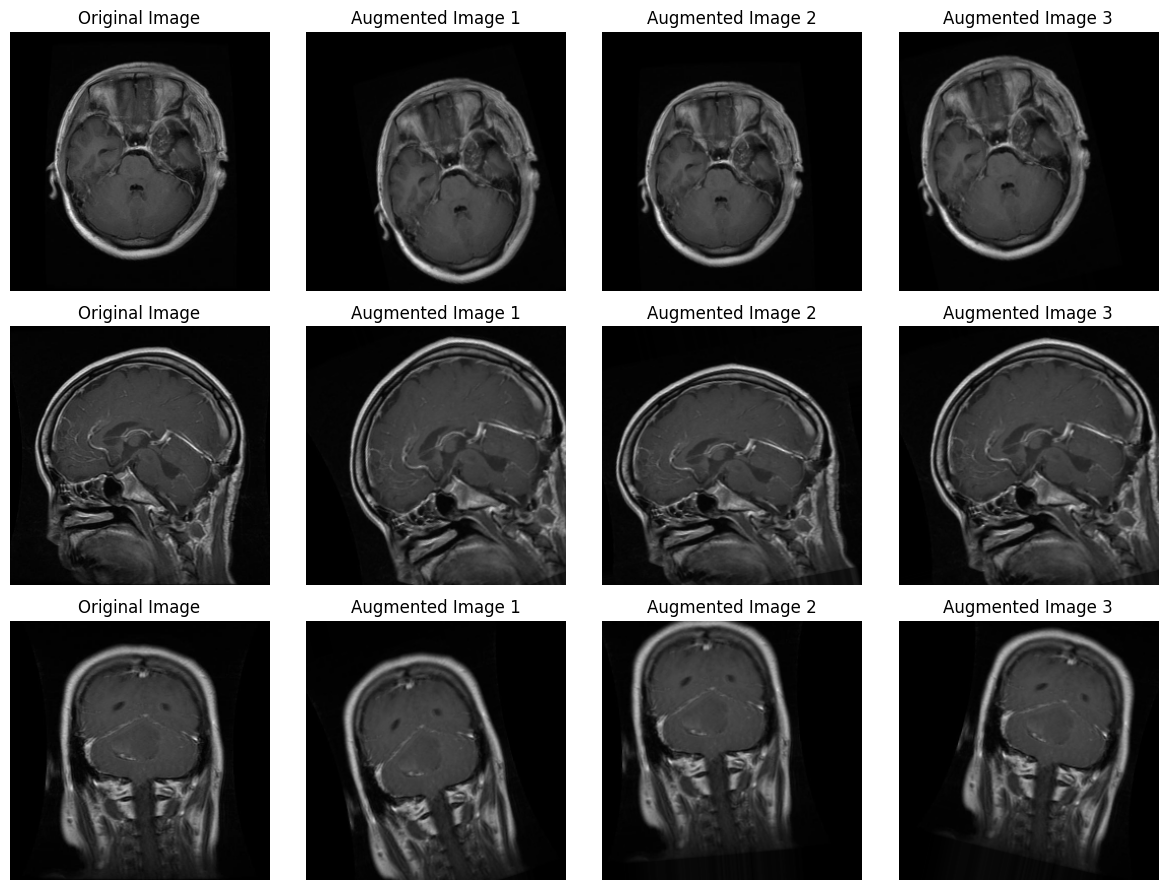

In [ ]:
def visualize_augmented_images(image_generator, num_samples, num_augmented_images):
    augmented_images = []
    for sample in X_train[:num_samples]:

        # Create a list to store augmented versions of a sample
        augmented_samples = [sample]
        for _ in range(num_augmented_images):
            augmented_samples.append(image_generator.random_transform(sample))
        augmented_images.append(augmented_samples)

    # Plot original and augmented images
    fig, axes = plt.subplots(num_samples, num_augmented_images + 1, figsize=( 12, num_samples * 3))
    for i, sample in enumerate(augmented_images):
        for j, image in enumerate(sample):
            axes[i,j].imshow(image)
            if j == 0:
                axes[i, j].set_title('Original Image')
            else:
                axes[i,j].set_title(f'Augmented Image {j}')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

#Visualize augmented images to see how it works
visualize_augmented_images(datagen, num_samples=3, num_augmented_images=3)

## Data Preparation

In [10]:
# Convert y_train labels to one-hot encoded format using pandas
y_train = np.array(pd.get_dummies(y_train))

In [11]:
#Split the dataset into training, testing and validation sets
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f'X_train shape: {(X_train).shape}\n'
      f'y_train shape: {(y_train).shape}\n'
      f'X_train shape: {(X_test).shape}\n'
      f'y_train shape: {(y_test).shape}\n'
      f'y_train shape: {(X_valid).shape}\n'
      f'X_train shape: {(y_valid).shape}')

X_train shape: (2643, 256, 256, 3)
y_train shape: (2643, 4)
X_train shape: (327, 256, 256, 3)
y_train shape: (327, 4)
y_train shape: (294, 256, 256, 3)
X_train shape: (294, 4)


## Normalization

In [12]:
# Normalize pixel values of training images to the range [0,1]
X_train = X_train / 255
X_test = X_test / 255
X_valid = X_valid / 255

print(f"Maximum and Minimum pixel value after normalization: {X_train.max()} - {X_train.min()}")

Maximum and Minimum pixel value after normalization: 1.0 - 0.0


## Model with Data Augmentation

In [ ]:
# Define the model
model = Sequential()

# An Input layer specifying the input shape
model.add(Input(shape=(256, 256, 3)))

model.add(Conv2D(16, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(16, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))   # the Softmax function works for multiclass classification problems
                                            # and the Sigmoid function is a better option for binary-class problems.


model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 16)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 16)        │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 564,948 (2.16 MB)

 Trainable params: 564,948 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
start_time = time.time()

history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    validation_data=(X_valid, y_valid),
                    epochs=20, verbose=1)

end_time = time.time()

runtime = end_time - start_time
print("Total runtime:", runtime, "seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - accuracy: 0.3299 - loss: 1.3646 - val_accuracy: 0.4728 - val_loss: 1.2998
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step - accuracy: 0.3925 - loss: 1.2764 - val_accuracy: 0.4626 - val_loss: 1.2124
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 179s 4s/step - accuracy: 0.4380 - loss: 1.2058 - val_accuracy: 0.4626 - val_loss: 1.2799
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 175s 4s/step - accuracy: 0.4891 - loss: 1.1589 - val_accuracy: 0.5000 - val_loss: 1.0864
Epoch 5/20
 4/42 ━━━━━━━━━━━━━━━━━━━━ 2:34 4s/step - accuracy: 0.4635 - loss: 1.1371

KeyboardInterrupt: 

In [ ]:
model.save("my_model.h5")

In [ ]:
model = tf.keras.models.load_model("my_model.h5")

## Confusion Matrix

In [ ]:
y_true = np.argmax(y_train, axis=1)
y_pred = np.argmax(model.predict(X_train), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Evaluation

In [ ]:
# 0 - Glioma Tumor
# 1 - No Tumor
# 2 - Meningioma Tumor
# 3 - Pituitary Tumor
print(classification_report(y_true_test,y_pred_test))

## Prediction

In [ ]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 256, 256, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

In [7]:
model = tf.keras.models.load_model("my_model_without_aug.h5")


In [15]:
labels

['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


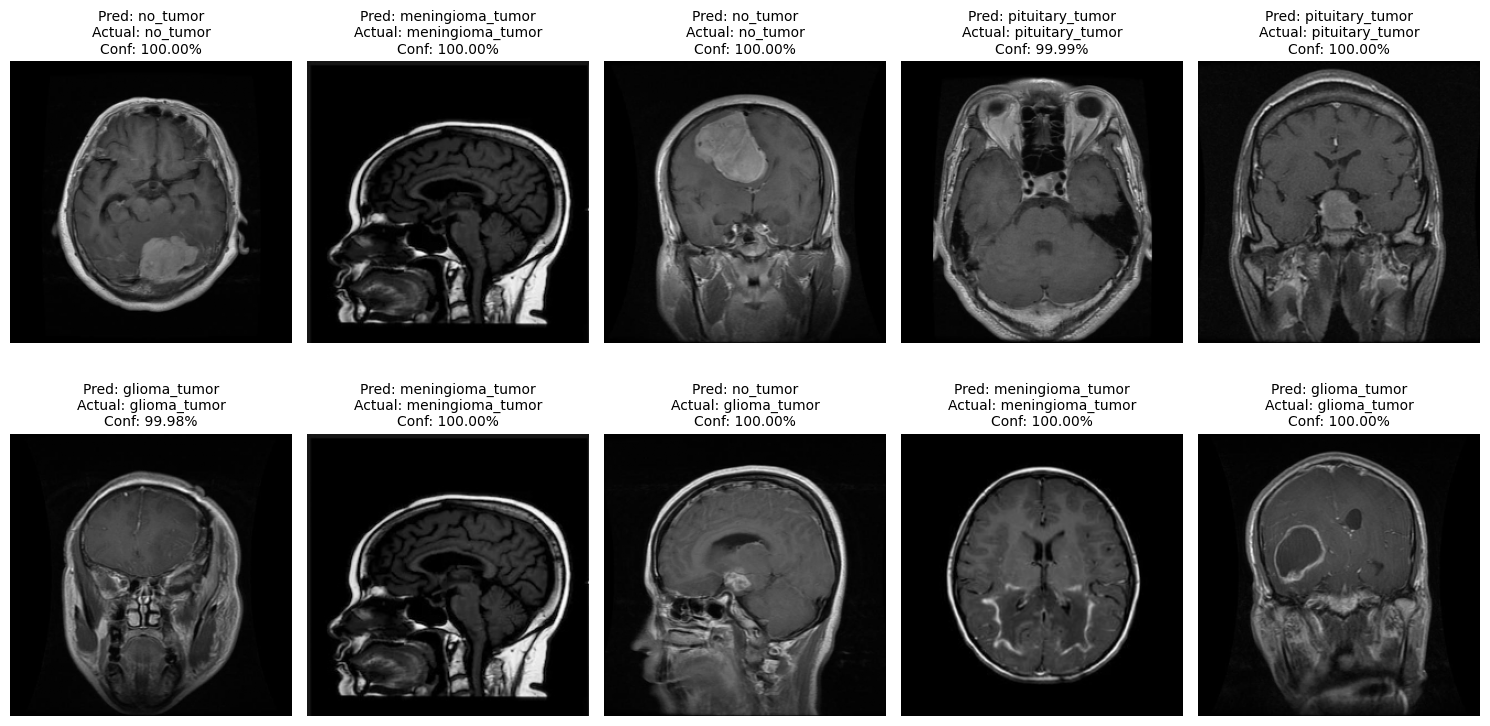


Image 1:
Predicted label: no_tumor
Actual label: no_tumor
Confidence: 100.00%

Image 2:
Predicted label: meningioma_tumor
Actual label: meningioma_tumor
Confidence: 100.00%

Image 3:
Predicted label: no_tumor
Actual label: no_tumor
Confidence: 100.00%

Image 4:
Predicted label: pituitary_tumor
Actual label: pituitary_tumor
Confidence: 99.99%

Image 5:
Predicted label: pituitary_tumor
Actual label: pituitary_tumor
Confidence: 100.00%

Image 6:
Predicted label: glioma_tumor
Actual label: glioma_tumor
Confidence: 99.98%

Image 7:
Predicted label: meningioma_tumor
Actual label: meningioma_tumor
Confidence: 100.00%

Image 8:
Predicted label: no_tumor
Actual label: glioma_tumor
Confidence: 100.00%

Image 9:
Predicted label: meningioma_tumor
Actual label: meningioma_tumor
Confidence: 100.00%

Image 10:
Predicted label: glioma_tumor
Actual label: glioma_tumor
Confidence: 100.00%


In [20]:
random_indexes = np.random.randint(0, len(X_test), 10)
random_imgs = X_test[random_indexes]
predictions = [model.predict(random_img.reshape(1, 256, 256, 3)) for random_img in random_imgs]  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_classes = [np.argmax(prediction) for prediction in predictions]  # Get the index of the class with the highest probability
predicted_labels = [labels[predicted_class] for predicted_class in predicted_classes]  # Convert class to label
confidences = [prediction[0][predicted_class] for prediction, predicted_class in zip(predictions, predicted_classes)]

actual_indexes = [y_test[random_index] for random_index in random_indexes]  # Get the one-hot encoded actual class
actual_classes = [np.argmax(actual_index) for actual_index in actual_indexes]
actual_labels = [labels[actual_class] for actual_class in actual_classes]

plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
    plt.imshow(random_imgs[i])
    plt.title(f"Pred: {predicted_labels[i]}\nActual: {actual_labels[i]}\nConf: {confidences[i]*100:.2f}%",
              fontsize=10, color='black')
    plt.axis('off')
plt.tight_layout()
plt.show()

for i in range(10):
    print(f"\nImage {i+1}:")
    print(f"\033[94mPredicted label: {predicted_labels[i]}\033[0m")
    print(f"\033[92mActual label: {actual_labels[i]}\033[0m")
    print(f"\033[93mConfidence: {confidences[i]*100:.2f}%\033[0m")